In [3]:
import scda
import os
import shutil
import numpy as np

import matplotlib.pyplot as plt
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['axes.linewidth'] = 1.
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 12

import logging
scda.configure_log()

Populating the interactive namespace from numpy and matplotlib


# Prepare two APLC designs, with and without LS alignment tolerance

## Set the design parameters

In [13]:
pupil_params = {'N': 125, 'prim':'hex3', 'centobs':True, 'secobs':'X', 'thick':'025'}
fpm_params = {'rad': 4., 'M': 60}
ls_params_aligntol = {'obscure':0, 'id':25, 'od':80, 'aligntol':5, 'aligntolcon':3.}
ls_params_noaligntol = {'obscure':0, 'id':25, 'od':80, 'aligntol':None}
image_params = {'c': 10., 'ida':-0.5, 'oda':10., 'bw':0.15, 'Nlam':5}

In [14]:
work_dir = "/astro/opticslab1/SCDA/Scripts/AMPL/scda_qpaplc_tests/"
if not os.path.exists(os.path.normpath(work_dir)):
    os.mkdir(work_dir)
#input_dir = "/astro/opticslab1/SCDA/Apertures/InputMasks" # location of input TelAp, FPM, and LS arrays
input_dir = "/astro/opticslab1/SCDA/Scripts/AMPL/scda_qpaplc_tests/InputMasks/"
TelAp_dir = os.path.join(input_dir, "TelAp")
FPM_dir = os.path.join(input_dir, "FPM")
LS_dir = os.path.join(input_dir, "LS")

In [15]:
design_params_aligntol = {'Pupil': pupil_params, 'FPM': fpm_params,
                          'LS': ls_params_aligntol, 'Image': image_params}
design_params_noaligntol = {'Pupil': pupil_params, 'FPM': fpm_params,
                            'LS': ls_params_noaligntol, 'Image': image_params}
fileorg = {'work dir': work_dir, 'TelAp dir': TelAp_dir,
           'FPM dir': FPM_dir, 'LS dir': LS_dir}
bar_solver = {'method': 'bar'}
barhom_solver = {'method': 'barhom'}

## Initiate the coronagraph objects

In [16]:
hexap_coron_aligntol = scda.QuarterplaneAPLC(design=design_params_aligntol, fileorg=fileorg, solver=barhom_solver)
hexap_coron_noaligntol = scda.QuarterplaneAPLC(design=design_params_noaligntol, fileorg=fileorg, solver=barhom_solver)

## Show the file organization for both coronagraphs

In [33]:
#hexap_coron_aligntol.fileorg

In [34]:
#hexap_coron_noaligntol.fileorg

### Check the status of input files needed to run the AMPL program

In [19]:
hexap_coron_aligntol.check_ampl_input_files()
print("All the input files for AMPL are in place? {0:}".format(hexap_coron_aligntol.ampl_infile_status))

All the input files for AMPL are in place? True


In [35]:
hexap_coron_noaligntol.check_ampl_input_files()
print("All the input files for AMPL are in place? {0:}".format(hexap_coron_noaligntol.ampl_infile_status))

All the input files for AMPL are in place? True


## Write the AMPL source file

In [37]:
hexap_coron_aligntol.write_ampl(override_infile_status=False, overwrite=False)
hexap_coron_noaligntol.write_ampl(override_infile_status=False, overwrite=False)

## Write serial bash execution script

In [ ]:
bash_fname = os.path.join(hexap_coron_aligntol.fileorg['ampl src dir'], 'run_LDZ_test.sh')
bash_fobj = open(bash_fname, "w")
bash_fobj.write("#! /bin/bash -x\n")
bash_fobj.write("ampl {0:s}\n".format(hexap_coron_noaligntol.fileorg['ampl src fname']))
bash_fobj.write("ampl {0:s}\n".format(hexap_coron_aligntol.fileorg['ampl src fname']))
bash_fobj.close()
os.chmod(bash_fname, 0775)
print("Wrote serial bash execution script to {0:s}".format(bash_fname))

## Create a bundled source + input file subdirectory for both designs

In [ ]:
bundled_dir = "/astro/opticslab1/SCDA/Scripts/AMPL/aplc_hex3ap_bw20"
bundled_coron_list = scda.make_ampl_bundle([hexap_coron_noaligntol, hexap_coron_aligntol],
                                           bundled_dir, queue_spec='auto', email='ntz@stsci.edu')
os.listdir(bundled_dir)

## Evaluate basic coronagraph metrics

In [38]:
hexap_coron_noaligntol.get_metrics()

Non-binary residuals, as a percentage of clear telescope aperture area: 0.32%
Band-averaged Airy throughput: 39.70%
Band-averaged FWHM PSF area / (lambda0/D)^2: 1.32


In [39]:
hexap_coron_aligntol.get_metrics()

Non-binary residuals, as a percentage of clear telescope aperture area: 2.08%
Band-averaged Airy throughput: 38.27%
Band-averaged FWHM PSF area / (lambda0/D)^2: 1.31


# Full-plane on-axis PSF evaluation

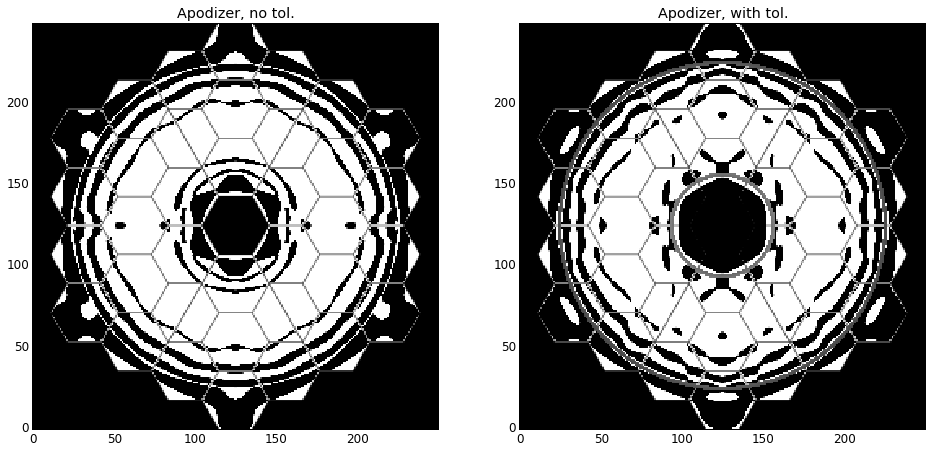

In [23]:
TelAp_qp = np.loadtxt(hexap_coron_noaligntol.fileorg['TelAp fname'])
TelAp = np.concatenate((np.concatenate((TelAp_qp[::-1,::-1], TelAp_qp[:,::-1]),axis=0),
                        np.concatenate((TelAp_qp[::-1,:], TelAp_qp),axis=0)), axis=1)

FPM_qp = np.loadtxt(hexap_coron_noaligntol.fileorg['FPM fname'])
FPM = np.concatenate((np.concatenate((FPM_qp[::-1,::-1], FPM_qp[:,::-1]),axis=0),
                      np.concatenate((FPM_qp[::-1,:], FPM_qp),axis=0)), axis=1)

LS_qp = np.loadtxt(hexap_coron_noaligntol.fileorg['LS fname'])
LS = np.concatenate((np.concatenate((LS_qp[::-1,::-1], LS_qp[:,::-1]),axis=0),
                     np.concatenate((LS_qp[::-1,:], LS_qp),axis=0)), axis=1)

LDZ_qp = np.loadtxt(hexap_coron_aligntol.fileorg['LDZ fname'])
LDZ = np.concatenate((np.concatenate((LDZ_qp[::-1,::-1], LDZ_qp[:,::-1]),axis=0),
                      np.concatenate((LDZ_qp[::-1,:], LDZ_qp),axis=0)), axis=1)

An_col = np.loadtxt(hexap_coron_noaligntol.fileorg['sol fname'])[:,-1]
An_qp = An_col.reshape(TelAp_qp.shape)
An = np.concatenate((np.concatenate((An_qp[::-1,::-1], An_qp[:,::-1]),axis=0),
                     np.concatenate((An_qp[::-1,:], An_qp),axis=0)), axis=1)
At_col = np.loadtxt(hexap_coron_aligntol.fileorg['sol fname'])[:,-1]
At_qp = At_col.reshape(TelAp_qp.shape)
At = np.concatenate((np.concatenate((At_qp[::-1,::-1], At_qp[:,::-1]),axis=0),
                     np.concatenate((At_qp[::-1,:], At_qp),axis=0)), axis=1)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(An*TelAp)
plt.title('Apodizer, no tol.')
plt.subplot(122)
plt.imshow(At*TelAp)
plt.title('Apodizer, with tol.')

## Create translated Lyot stop, check against design tolerance

In [24]:
test_shift = (0,1)
max_shift_tol = LS.shape[0]*float(hexap_coron_aligntol.design['LS']['aligntol'])/1000
max_shift_tol_int = int(np.floor(max_shift_tol))
print("The LDZ accomomdates a translation {0:.1f}% of D={1:d} pixels = {2:.2f} pixels, up to {3:d} whole pixels".format(
      float(hexap_coron_aligntol.design['LS']['aligntol'])/10, LS.shape[0], max_shift_tol, max_shift_tol_int))
print("Testing an (x,y) translation of {0:} pixels. Beyond the design tolerance? {1:}".format(
      test_shift, test_shift[0]**2 + test_shift[1]**2 > max_shift_tol))
LSe = np.roll(np.roll(LS, test_shift[0], axis=1), test_shift[1], axis=0)
LS_err_mask = np.ceil(np.abs(LSe - LS)).astype(bool)

print("LDZ encompasses the LS transmission error region? {0:}".format(
        ~np.any(np.logical_and(LS_err_mask, ~LDZ.astype(bool)))))

print("Total unconstrained \"leak\" area after translation = {0:d} pixels".format(
      int(np.sum(np.logical_and(LS_err_mask, ~LDZ.astype(bool))))))

The LDZ accomomdates a translation 0.5% of D=250 pixels = 1.25 pixels, up to 1 whole pixels
Testing an (x,y) translation of (0, 1) pixels. Beyond the design tolerance? False
LDZ encompasses the LS transmission error region? True
Total unconstrained "leak" area after translation = 0 pixels


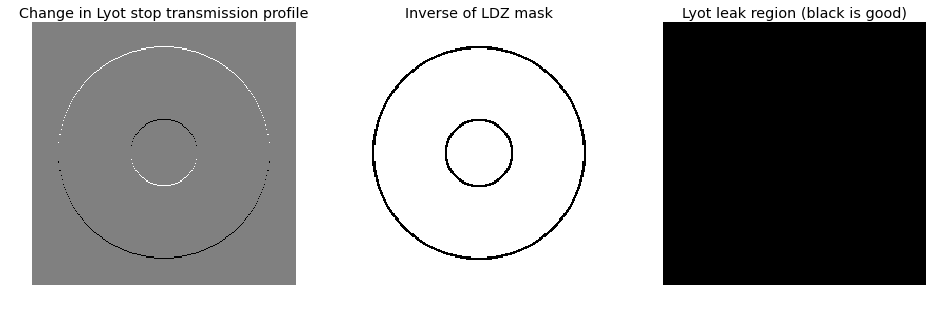

In [25]:
plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(LSe - LS)
lims = plt.axis('off')
t=plt.title('Change in Lyot stop transmission profile')
plt.subplot(132)
plt.imshow(~LDZ.astype(bool))
lims = plt.axis('off')
t=plt.title('Inverse of LDZ mask')
plt.subplot(133)
plt.imshow(np.logical_and(LS_err_mask, ~LDZ.astype(bool)))
lims = plt.axis('off')
t=plt.title('Lyot leak region (black is good)')

## Define coordinates and dimensions

In [26]:
D = 1.
N = hexap_coron_aligntol.design['Pupil']['N']
bw = hexap_coron_aligntol.design['Image']['bw']
Nlambda = hexap_coron_aligntol.design['Image']['Nlam']
M_fp1 = hexap_coron_aligntol.design['FPM']['M']
fpm_rad = hexap_coron_aligntol.design['FPM']['rad']
rho2 = hexap_coron_aligntol.design['Image']['oda'] + 2.
fp2res = 8.
M_fp2 = int(np.ceil(rho2*fp2res))

# pupil plane
dx = (D/2)/N
dy = dx
xs = np.matrix(np.linspace(-N+0.5,N-0.5,2*N)*dx)
ys = xs

# FPM
dmx = fpm_rad/M_fp1
dmy = dmx
mxs = np.matrix(np.linspace(-M_fp1+0.5,M_fp1-0.5,2*M_fp1)*dmx)
mys = mxs

# FP2
dxi = 1/fp2res
xis = np.matrix(np.linspace(-M_fp2+0.5,M_fp2-0.5,2*M_fp2)*dxi)
etas = xis

# wavelength ratios
wrs = np.linspace(1.-bw/2, 1.+bw/2, Nlambda)

## Fourier propagation

In [27]:
def get_onax_aplc_psf(TelAp, A, FPM, LS, xs, dx, mxs, dmx, xis, dxi, wrs):
    intens_D_polychrom = []
    for wr in wrs:
        Psi_B = dx*dx/wr*np.dot(np.dot(np.exp(-1j*2*np.pi/wr*np.dot(mxs.T, xs)), TelAp*A ),
                                       np.exp(-1j*2*np.pi/wr*np.dot(xs.T, mxs)))
        Psi_B_stop = np.multiply(Psi_B, FPM)
        Psi_C = A*TelAp - dmx*dmx/wr*np.dot(np.dot(np.exp(-1j*2*np.pi/wr*np.dot(xs.T, mxs)), Psi_B_stop),
                                                   np.exp(-1j*2*np.pi/wr*np.dot(mxs.T, xs)))
        Psi_C_stop = np.multiply(Psi_C, LS)
        Psi_D = dx*dx/wr*np.dot(np.dot(np.exp(-1j*2*np.pi/wr*np.dot(xis.T, xs)), Psi_C_stop),
                                       np.exp(-1j*2*np.pi/wr*np.dot(xs.T, xis)))
        Psi_D_0_peak = np.sum(A*TelAp*LS)*dx*dx/wr
        intens_D_polychrom.append(np.power(np.absolute(Psi_D)/Psi_D_0_peak, 2))
    return intens_D_polychrom

In [28]:
intens_n_polychrom = get_onax_aplc_psf(TelAp, An, FPM, LS, xs, dx, mxs, dmx, xis, dxi, wrs)
intens_ne_polychrom = get_onax_aplc_psf(TelAp, An, FPM, LSe, xs, dx, mxs, dmx, xis, dxi, wrs)
intens_t_polychrom = get_onax_aplc_psf(TelAp, At, FPM, LS, xs, dx, mxs, dmx, xis, dxi, wrs)
intens_te_polychrom = get_onax_aplc_psf(TelAp, At, FPM, LSe, xs, dx, mxs, dmx, xis, dxi, wrs)

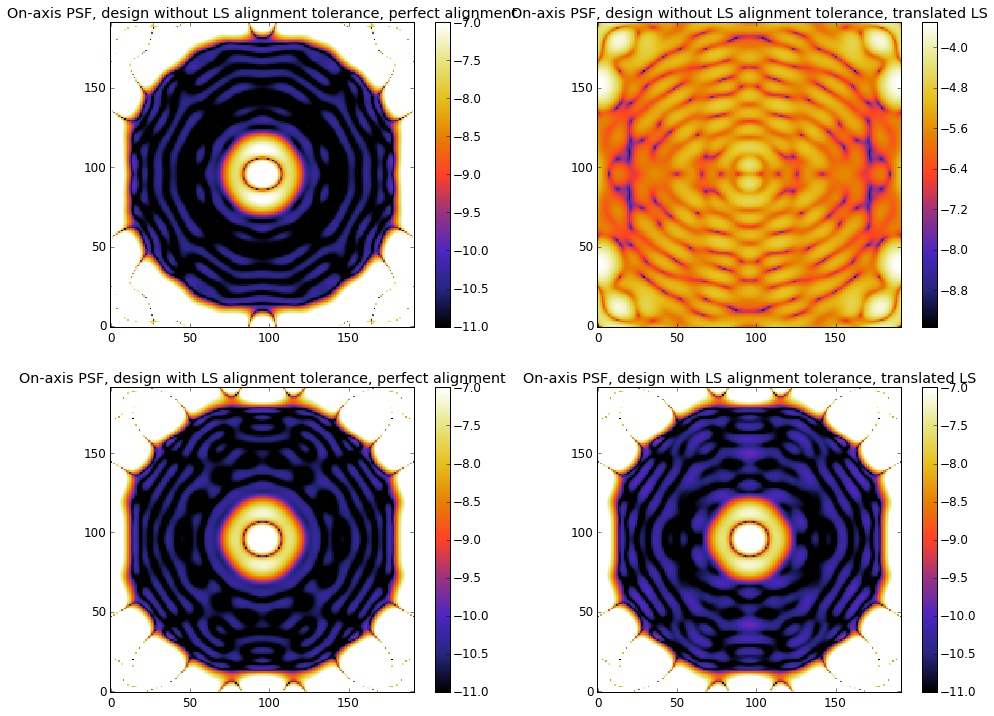

In [29]:
plt.figure(figsize=(16,12))
plt.subplot(221)
plt.imshow(np.log10(intens_n_polychrom[2]), vmin=-11, vmax=-7, cmap='CMRmap')
plt.colorbar()
plt.title('On-axis PSF, design without LS alignment tolerance, perfect alignment')

plt.subplot(222)
plt.imshow(np.log10(intens_ne_polychrom[2]), cmap='CMRmap')
plt.colorbar()
plt.title('On-axis PSF, design without LS alignment tolerance, translated LS')

plt.subplot(223)
plt.imshow(np.log10(intens_t_polychrom[2]), vmin=-11, vmax=-7, cmap='CMRmap')
plt.colorbar()
plt.title('On-axis PSF, design with LS alignment tolerance, perfect alignment')

plt.subplot(224)
plt.imshow(np.log10(intens_te_polychrom[2]), vmin=-11, vmax=-7, cmap='CMRmap')
plt.colorbar()
plt.title('On-axis PSF, design with LS alignment tolerance, translated LS')

## Intensity curve

In [30]:
def get_radial_intens(intens_polychrom, xis, seps, wrs):
    radial_intens_polychrom = np.zeros((len(wrs), len(seps)))
    XXs = np.asarray(np.dot(np.matrix(np.ones(xis.shape)).T, xis))
    YYs = np.asarray(np.dot(etas.T, np.matrix(np.ones(etas.shape))))
    RRs = np.sqrt(XXs**2 + YYs**2)

    for si, sep in enumerate(seps):
        r_in = np.max([seps[0], sep-0.5])
        r_out = np.min([seps[-1], sep+0.5])
        meas_ann_mask = np.logical_and(np.greater_equal(RRs, r_in),
                                       np.less_equal(RRs, r_out))
        #meas_ann_ind = np.nonzero(meas_ann_mask)
        meas_ann_ind = np.nonzero(np.logical_and(np.greater_equal(RRs, r_in).ravel(),
                                                 np.less_equal(RRs, r_out).ravel()))[0]
        for wi, wr in enumerate(wrs):
            radial_intens_polychrom[wi, si] = np.mean(np.ravel(intens_polychrom[wi])[meas_ann_ind])
    return radial_intens_polychrom

In [31]:
rho0 = hexap_coron_aligntol.design['FPM']['rad'] + hexap_coron_aligntol.design['Image']['ida']
rho1 = hexap_coron_aligntol.design['Image']['oda'] + 1
seps = np.arange(rho0, rho1, 0.25)

radial_intens_n_polychrom = get_radial_intens(intens_n_polychrom, xis, seps, wrs)
radial_intens_ne_polychrom = get_radial_intens(intens_ne_polychrom, xis, seps, wrs)
radial_intens_t_polychrom = get_radial_intens(intens_t_polychrom, xis, seps, wrs)
radial_intens_te_polychrom = get_radial_intens(intens_te_polychrom, xis, seps, wrs)

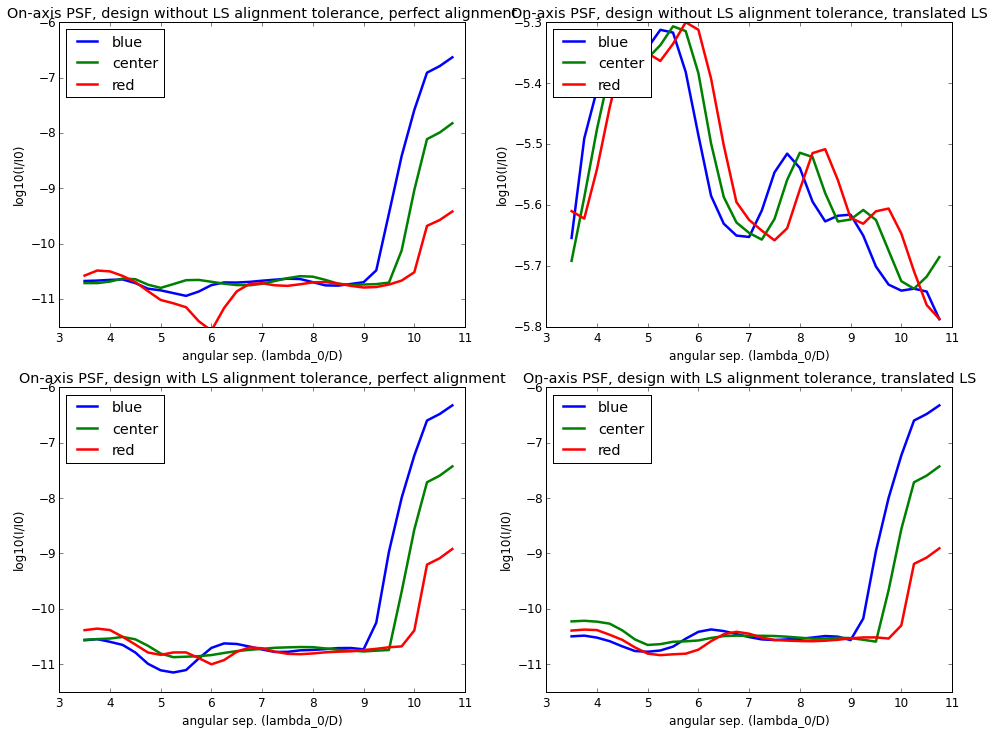

In [32]:
plt.figure(figsize=(16,12))

plt.subplot(221)
plt.plot(seps, np.log10(radial_intens_n_polychrom[0]))
plt.plot(seps, np.log10(radial_intens_n_polychrom[1]))
plt.plot(seps, np.log10(radial_intens_n_polychrom[2]))
plt.legend(['blue','center','red'], loc='upper left')
plt.ylim([-11.5, -6])
plt.xlabel('angular sep. (lambda_0/D)')
plt.ylabel('log10(I/I0)')
plt.title('On-axis PSF, design without LS alignment tolerance, perfect alignment')

plt.subplot(222)
plt.plot(seps, np.log10(radial_intens_ne_polychrom[0]))
plt.plot(seps, np.log10(radial_intens_ne_polychrom[1]))
plt.plot(seps, np.log10(radial_intens_ne_polychrom[2]))
plt.legend(['blue','center','red'], loc='upper left')
plt.xlabel('angular sep. (lambda_0/D)')
plt.ylabel('log10(I/I0)')
plt.title('On-axis PSF, design without LS alignment tolerance, translated LS')

plt.subplot(223)
plt.plot(seps, np.log10(radial_intens_t_polychrom[0]))
plt.plot(seps, np.log10(radial_intens_t_polychrom[1]))
plt.plot(seps, np.log10(radial_intens_t_polychrom[2]))
plt.legend(['blue','center','red'], loc='upper left')
plt.ylim([-11.5, -6])
plt.xlabel('angular sep. (lambda_0/D)')
plt.ylabel('log10(I/I0)')
plt.title('On-axis PSF, design with LS alignment tolerance, perfect alignment')

plt.subplot(224)
plt.plot(seps, np.log10(radial_intens_te_polychrom[0]))
plt.plot(seps, np.log10(radial_intens_te_polychrom[1]))
plt.plot(seps, np.log10(radial_intens_te_polychrom[2]))
plt.legend(['blue','center','red'], loc='upper left')
plt.ylim([-11.5, -6])
plt.xlabel('angular sep. (lambda_0/D)')
plt.ylabel('log10(I/I0)')
plt.title('On-axis PSF, design with LS alignment tolerance, translated LS')